# 4 Домашние задание по ТВиМС

### Импорт библиотек

In [1]:
from itertools import combinations

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

### Найстроки графиков

In [2]:
sns.set(style="whitegrid")

## №1 Данные

Я выбрал данные из датасета [**kion**](https://github.com/irsafilo/KION_DATASET). Сегментами будут являться возраста, а именно: 18-24, 25-34, 35-44, 45-54, 55-64, 65 и более. Признаки, числовые характеристики: количество просмотров всех фильмов, средний процент досмтариваемости, количество просмотренных фильмов для детей.  

In [3]:
users_df = pd.read_csv('data/users.csv')
items_df = pd.read_csv('data/items.csv')
interactions_df = pd.read_csv('data/interactions.csv')

Так для некотрых пользователей мы не знаем их возраста. Уберем их из данных.

In [4]:
users_df['age'].isna().sum()

14095

In [5]:
users_df = users_df[users_df['age'].notna()]

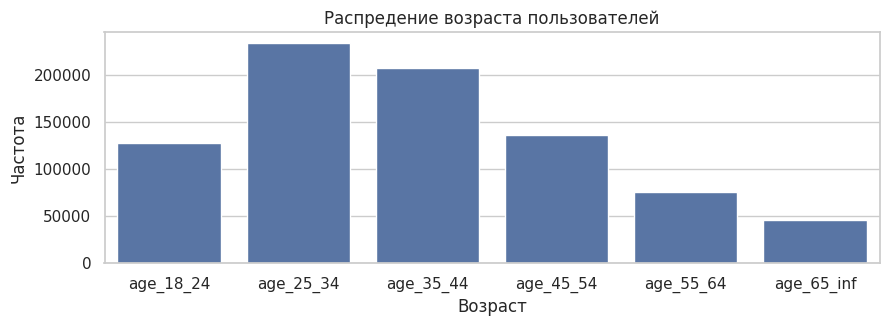

In [6]:
custom_order = ['age_18_24', 
                'age_25_34', 
                'age_35_44',
                'age_45_54', 
                'age_55_64', 
                'age_65_inf']

plt.figure(figsize=(10, 3))
sns.countplot(users_df, x='age', order=custom_order)
plt.title('Распредение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

Переименуем признак возраста.

In [7]:
users_df['age'].replace(['age_18_24', 
                         'age_25_34', 
                         'age_35_44',
                         'age_45_54', 
                         'age_55_64', 
                         'age_65_inf'],
                        ['18_24', 
                         '25_34', 
                         '35_44',
                         '45_54', 
                         '55_64', 
                         '65_inf'],
                       inplace=True)

Посчитем первый признак. Для каждого пользователя найдем количество фильмов, которые он смотрел.

In [8]:
count_views = interactions_df[['user_id', 'item_id']]\
                    .groupby('user_id')\
                    .count()\
                    .rename(columns={'item_id': 'cnt_views'})

users_df = users_df.join(count_views, on='user_id')

Посчитем второй признак. Для каждого пользователя найдем средний процент просмотренности фильма.

In [9]:
mean_watched_pct = interactions_df[['user_id', 'watched_pct']]\
                        .groupby('user_id')\
                        .mean()\
                        .rename(columns={'watched_pct': 'mean_watched_pct'})

users_df = users_df.join(mean_watched_pct, on='user_id')
users_df['mean_watched_pct'] = np.round(users_df['mean_watched_pct']) 

Посчитем третий признак. Для каждого пользователя найдем количество просмотренных фильмов для детей.

In [10]:
for_kids = interactions_df[['user_id', 'item_id']]\
                .join(items_df[['age_rating', 'item_id']]\
                .set_index('item_id'), on='item_id')\
                .rename(columns={'age_rating': 'cnt_kids_films'})

for_kids['cnt_kids_films'] = for_kids['cnt_kids_films'] < 16
for_kids = for_kids[['user_id', 'cnt_kids_films']]\
                .groupby('user_id')\
                .sum()

users_df = users_df.join(for_kids, on='user_id')

Уберем лишние признаки для данных, с которыми будем работать.

In [11]:
df = users_df[['age', 
               'cnt_views', 
               'mean_watched_pct', 
               'cnt_kids_films']]
df.sample(10)

,age,cnt_views,mean_watched_pct,cnt_kids_films
288376,45_54,2.0,2.0,0.0
578757,45_54,4.0,46.0,0.0
90293,55_64,1.0,100.0,0.0
392850,25_34,1.0,1.0,0.0
705537,45_54,10.0,93.0,9.0
722874,55_64,1.0,20.0,1.0
320324,45_54,56.0,34.0,14.0
492605,45_54,29.0,66.0,11.0
498513,55_64,9.0,75.0,0.0
111771,35_44,3.0,59.0,0.0


Уберем записи о пользователях, в признаках которых встречается NaN. Nan появились из-за того, что далеко не все пользователя смотрели что-то хотя бы один раз. Эти пропуски сильно будут влиять на тесты, которые мы будем проводить.

In [12]:
df = df.dropna()

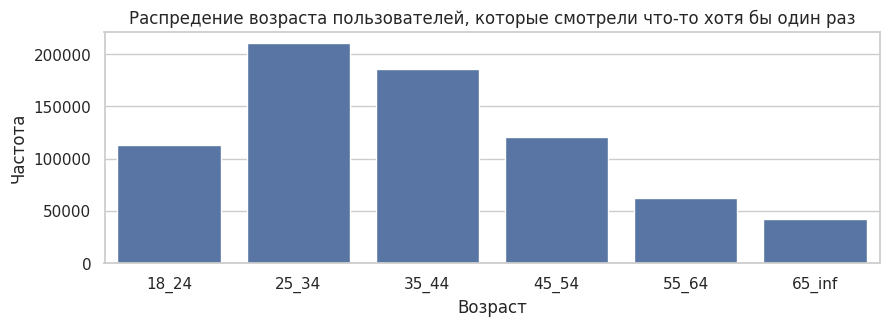

In [13]:
custom_order = ['18_24', 
                '25_34', 
                '35_44',
                '45_54', 
                '55_64', 
                '65_inf']

plt.figure(figsize=(10, 3))
sns.countplot(df, x='age', order=custom_order)
plt.title('Распредение возраста пользователей, которые смотрели что-то хотя бы один раз')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

## №2 Применение тестов Стьюдента, Манна-Уитни, Фишера (для нескольких сегментов)

### Тест Стьюдента
Провередем тесты Стьюдента для возрастных групп 18-24 и 65 и более.

In [14]:
metrics = ['cnt_views',
           'mean_watched_pct',
           'cnt_kids_films']
for metric in metrics:
    _, p_val = stats.ttest_ind(df.query("age == '18_24'")[metric], 
                               df.query("age == '65_inf'")[metric])
    print(f'{metric}: {p_val}')

cnt_views: 0.08778024237748007
mean_watched_pct: 6.275798940358824e-149
cnt_kids_films: 1.7840100863820155e-13


### Тест Манна-Уитни
Провередем тесты Стьюдента для тех же возрастных групп.

In [15]:
for metric in metrics:
    _, p_val = stats.mannwhitneyu(df.query("age == '18_24'")[metric], 
                                  df.query("age == '65_inf'")[metric])
    print(f'{metric}: {p_val}')

cnt_views: 9.733071630030043e-75
mean_watched_pct: 1.1088343907061169e-184
cnt_kids_films: 8.603446562753938e-15


### Тест Фишера (для нескольких сегментов)

Проведем тест Фишера для всех возрастных групп.

In [16]:
for metric in metrics:
    segments = []
    for age in df['age'].unique():
        segments.append(df.query(f"age == '{age}'")[metric])
    _, p_val = stats.f_oneway(*segments)
    print(f'{metric}: {p_val}')

cnt_views: 0.0
mean_watched_pct: 0.0
cnt_kids_films: 2.231627320620442e-303


### Промежуточный итог

Результаты тестов Стьюдента и Манна-Уитни отличаются для метрики количества просмотров потому что тест Манна-Уитни не подходит для сравнения средних, поэтому его результаты нельзя использовать для построения выводов. В остальном мы увидели, что сегменты для выбранных метрик отличаются друг от друга. То есть средний процент просмотра и количество просмотренных детских фильмов отличаются для разных возрастных групп.

Используя тест Фишера так же было обнаружено, что хотя бы один сегмент отличается от других по всем метрикам.

## №3 Попарные сравнения для тестов через тест Стьюдента и тест Фишера

### Попарные сравнения через тест Стьюдента

In [17]:
result = []

for pair in combinations(df['age'].unique(), 2):
    _, p_val_cnt_views = stats.ttest_ind(df.query(f"age == '{pair[0]}'")['cnt_views'], 
                                         df.query(f"age == '{pair[1]}'")['cnt_views'])
    _, p_val_mean_watched = stats.ttest_ind(df.query(f"age == '{pair[0]}'")['mean_watched_pct'], 
                                            df.query(f"age == '{pair[1]}'")['mean_watched_pct'])
    _, p_val_cnt_kids_film = stats.ttest_ind(df.query(f"age == '{pair[0]}'")['cnt_kids_films'], 
                                             df.query(f"age == '{pair[1]}'")['cnt_kids_films'])
    result.append({'Пара': ' - '.join(pair),
                   'Количество просмотров': p_val_cnt_views,
                   'Среднее время просмотра': p_val_mean_watched,
                   'Количество просмотренных детских фильмов': p_val_cnt_kids_film})
    
pair_t_tests = pd.DataFrame(result)
pair_t_tests

,Пара,Количество просмотров,Среднее время просмотра,Количество просмотренных детских фильмов
0,25_34 - 18_24,1.962937e-173,1.104729e-20,2.115042e-80
1,25_34 - 45_54,1.287774e-04,5.381293e-116,4.083564e-23
2,25_34 - 35_44,3.186504e-46,2.614630e-04,1.991249e-15
3,25_34 - 55_64,1.573655e-30,4.899953e-281,1.601150e-73
4,25_34 - 65_inf,1.486488e-87,2.612355e-266,4.181839e-89
5,18_24 - 45_54,2.769409e-185,3.068641e-30,6.032983e-19
6,18_24 - 35_44,0.000000e+00,7.220130e-10,5.570438e-145
7,18_24 - 55_64,3.102180e-24,5.459678e-142,6.037016e-03
8,18_24 - 65_inf,8.778024e-02,6.275799e-149,1.784010e-13
9,45_54 - 35_44,1.866168e-17,1.776669e-84,1.266058e-63


### Тест Фишера

In [18]:
result = []

for pair in combinations(df['age'].unique(), 2):
    _, p_val_cnt_views = stats.f_oneway(df.query(f"age == '{pair[0]}'")['cnt_views'], 
                                         df.query(f"age == '{pair[1]}'")['cnt_views'])
    
    _, p_val_mean_watched = stats.f_oneway(df.query(f"age == '{pair[0]}'")['mean_watched_pct'], 
                                            df.query(f"age == '{pair[1]}'")['mean_watched_pct'])
    
    _, p_val_cnt_kids_film = stats.f_oneway(df.query(f"age == '{pair[0]}'")['cnt_kids_films'], 
                                             df.query(f"age == '{pair[1]}'")['cnt_kids_films'])
    
    result.append({'Пара': ' - '.join(pair),
                   'Количество просмотров': p_val_cnt_views,
                   'Среднее время просмотра': p_val_mean_watched,
                   'Количество просмотренных детских фильмов': p_val_cnt_kids_film})
    
pair_f_tests = pd.DataFrame(result)
pair_f_tests

,Пара,Количество просмотров,Среднее время просмотра,Количество просмотренных детских фильмов
0,25_34 - 18_24,1.962937e-173,1.104729e-20,2.115042e-80
1,25_34 - 45_54,1.287774e-04,5.381293e-116,4.083564e-23
2,25_34 - 35_44,3.186504e-46,2.614630e-04,1.991249e-15
3,25_34 - 55_64,1.573655e-30,4.899953e-281,1.601150e-73
4,25_34 - 65_inf,1.486488e-87,2.612355e-266,4.181839e-89
5,18_24 - 45_54,2.769409e-185,3.068641e-30,6.032983e-19
6,18_24 - 35_44,0.000000e+00,7.220130e-10,5.570438e-145
7,18_24 - 55_64,3.102180e-24,5.459678e-142,6.037016e-03
8,18_24 - 65_inf,8.778024e-02,6.275799e-149,1.784010e-13
9,45_54 - 35_44,1.866168e-17,1.776669e-84,1.266058e-63


### Промежуточный итог

Как мы видим, попарный тест Фишерра эквивалентен двухстороннему тесту стьюдента. Убедимся в этом не только наглядно.

In [19]:
np.abs(np.round(pair_t_tests.drop('Пара', axis=1) - pair_f_tests.drop('Пара', axis=1), 10)).sum().sum()

0.0

Округление необходимо, чтобы избежать проблемы [машинного нуля](https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D1%8B%D0%B9_%D0%BD%D0%BE%D0%BB%D1%8C).

## №4 Точный и эфронов доверительные интервал для выбранных метрик

Возьмем два сегмента 18-24 и 65 и более. Построим для них доверительные интервалы и сравним их с результатами теста Стьюдента из 2-го пункта.

Напишем функции для построения точно и эфронова доверительного интервала.

In [20]:
def calc_confidence_interval(data: pd.Series, 
                             confidence: float = 0.95
) -> list:
    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    df = n - 1
    interval = stats.t.interval(confidence, 
                                df, 
                                loc=mean, 
                                scale=std_dev / np.sqrt(n))
    return interval


def efron_confidence_interval(data: pd.Series, 
                              confidence: float = 0.95, 
                              num_bootstrap_samples: int = 1000
) -> list:
    n = len(data)
    bootstrap_samples = np.random.choice(data, size=(num_bootstrap_samples, n), 
                                         replace=True)
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    sorted_bootstrap_means = np.sort(bootstrap_means)
    alpha = (1 - confidence) / 2
    lower_index = int(alpha * num_bootstrap_samples)
    upper_index = int((1 - alpha) * num_bootstrap_samples)
    lower_bound = np.round(sorted_bootstrap_means[lower_index], 5)
    upper_bound = np.round(sorted_bootstrap_means[upper_index], 5)
    return lower_bound, upper_bound

In [21]:
metrics = ['cnt_views',
           'mean_watched_pct',
           'cnt_kids_films']

result = []

for metric in metrics:
    intrerval_18_24 = calc_confidence_interval(df.query("age == '18_24'")[metric])
    interval_65_inf = calc_confidence_interval(df.query("age == '65_inf'")[metric])
    intrerval_18_24 = np.round(intrerval_18_24, 5)
    interval_65_inf = np.round(interval_65_inf, 5)
    
    _, p_val = stats.ttest_ind(df.query("age == '18_24'")[metric], 
                               df.query("age == '65_inf'")[metric])
    p_val = np.round(p_val, 5)

    print(f'{metric}: {intrerval_18_24}, {interval_65_inf}, {p_val}')

cnt_views: [4.92321 5.03251], [4.76991 4.99045], 0.08778
mean_watched_pct: [38.54738 38.91404], [33.71899 34.33158], 0.0
cnt_kids_films: [1.52626 1.57402], [1.33857 1.41673], 0.0


In [22]:
metrics = ['cnt_views',
           'mean_watched_pct',
           'cnt_kids_films']

for metric in metrics:
    intrerval_18_24 = efron_confidence_interval(df.query("age == '18_24'")[metric])
    interval_65_inf = calc_confidence_interval(df.query("age == '65_inf'")[metric])
    intrerval_18_24 = np.round(intrerval_18_24, 5)
    interval_65_inf = np.round(interval_65_inf, 5)
    
    _, p_val = stats.ttest_ind(df.query("age == '18_24'")[metric], 
                               df.query("age == '65_inf'")[metric])
    p_val = np.round(p_val, 5)
    
    print(f'{metric}: {intrerval_18_24}, {interval_65_inf}, {p_val}')

cnt_views: [4.92027 5.0325 ], [4.76991 4.99045], 0.08778
mean_watched_pct: [38.54655 38.92852], [33.71899 34.33158], 0.0
cnt_kids_films: [1.52824 1.57404], [1.33857 1.41673], 0.0


Использование доверительных интервалов подтвердило результаты теста Стьюдента (доверительные интервалы не пересекаются там, где p-уровень значимости меньше 0.05). Но стоит помнить, что оценка статистик с использованием доверительных интервалов является менее точной, так как возрастает ошибка 2-го рода.

## №5 Статистические методы для 2-го пунтка

### Тест Колмогорова-Смирнова


In [23]:
_, p_val = stats.ks_2samp(df.query("age == '18_24'")['cnt_views'], 
                          df.query("age == '65_inf'")['cnt_views'])
p_val

1.4590258181624818e-78

Получили, что p-уровень значимости меньше 0.05 - распределения различны.

### Тест Левена

Тест Левена используется для проверки гипотезы о равенстве дисперсий между двумя или более группами. Этот тест, так же как и предыдущий, является непараметрическим - он не чувствителен к отклонениям от нормальности.

In [24]:
_, p_val = stats.levene(df.query("age == '18_24'")['cnt_views'], 
                        df.query("age == '65_inf'")['cnt_views'])
p_val

0.8460683772304081

Получили, что p-уровень значимости больше 0.05 - распределения имеют одинаковую дисперсию.